In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt 
import statsmodels.api as sm 
from statsmodels.tsa.api import Holt
plt.style.use('seaborn-whitegrid')
plt.rc('figure', autolayout=True, figsize = (20,10))
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('font', size = 20)
import prepare, acquire, model

# Time Series Mini Project

In [2]:
temp = pd.read_csv('GlobalLandTemperaturesByCity.csv')

In [3]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599212 entries, 0 to 8599211
Data columns (total 7 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   dt                             object 
 1   AverageTemperature             float64
 2   AverageTemperatureUncertainty  float64
 3   City                           object 
 4   Country                        object 
 5   Latitude                       object 
 6   Longitude                      object 
dtypes: float64(2), object(5)
memory usage: 459.2+ MB


## Planning:
- Let's do something fun. 80% of the hops in the US are grown in Yakima Valley, Washington. Let's check the city dataset to see if they have data for Yakima. 
- Clean up the dataset and figure out what to do with nulls, probably ffill temperature if possible
- Explore to determine potential trends or any other insights
- Create the forcast
- Evaluate the forcast
- If there is time, add a univariate LMST keras model onto it

In [4]:
temp[temp['City'] == 'Yakima']

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude


Doesn't have yakima, let's just do all of Washington State 

In [5]:
temp = pd.read_csv('GlobalLandTemperaturesByState.csv')
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645675 entries, 0 to 645674
Data columns (total 5 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             645675 non-null  object 
 1   AverageTemperature             620027 non-null  float64
 2   AverageTemperatureUncertainty  620027 non-null  float64
 3   State                          645675 non-null  object 
 4   Country                        645675 non-null  object 
dtypes: float64(2), object(3)
memory usage: 24.6+ MB


In [6]:
temp.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
0,1855-05-01,25.544,1.171,Acre,Brazil
1,1855-06-01,24.228,1.103,Acre,Brazil
2,1855-07-01,24.371,1.044,Acre,Brazil
3,1855-08-01,25.427,1.073,Acre,Brazil
4,1855-09-01,25.675,1.014,Acre,Brazil


In [7]:
temp[temp['State'] == 'Washington']

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
610320,1828-01-01,-4.446,2.546,Washington,United States
610321,1828-02-01,-0.973,2.081,Washington,United States
610322,1828-03-01,3.930,2.265,Washington,United States
610323,1828-04-01,NaN,NaN,Washington,United States
610324,1828-05-01,11.376,2.659,Washington,United States
...,...,...,...,...,...
612544,2013-05-01,12.286,0.259,Washington,United States
612545,2013-06-01,15.215,0.233,Washington,United States
612546,2013-07-01,19.717,0.216,Washington,United States
612547,2013-08-01,19.169,0.326,Washington,United States


In [8]:
wash = temp[temp['State'] == 'Washington'].copy()

In [9]:
wash

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
610320,1828-01-01,-4.446,2.546,Washington,United States
610321,1828-02-01,-0.973,2.081,Washington,United States
610322,1828-03-01,3.930,2.265,Washington,United States
610323,1828-04-01,NaN,NaN,Washington,United States
610324,1828-05-01,11.376,2.659,Washington,United States
...,...,...,...,...,...
612544,2013-05-01,12.286,0.259,Washington,United States
612545,2013-06-01,15.215,0.233,Washington,United States
612546,2013-07-01,19.717,0.216,Washington,United States
612547,2013-08-01,19.169,0.326,Washington,United States


#### Both dataframes have similar date columns, but they need to be converted to datetime

In [10]:
wash.loc[:,'dt'] = pd.to_datetime(wash['dt'])

In [11]:
wash.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2229 entries, 610320 to 612548
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   dt                             2229 non-null   datetime64[ns]
 1   AverageTemperature             2182 non-null   float64       
 2   AverageTemperatureUncertainty  2182 non-null   float64       
 3   State                          2229 non-null   object        
 4   Country                        2229 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 104.5+ KB


In [12]:
wash = wash.set_index('dt').sort_index()

In [13]:
wash

,AverageTemperature,AverageTemperatureUncertainty,State,Country
dt,,,,
1828-01-01,-4.446,2.546,Washington,United States
1828-02-01,-0.973,2.081,Washington,United States
1828-03-01,3.930,2.265,Washington,United States
1828-04-01,NaN,NaN,Washington,United States
1828-05-01,11.376,2.659,Washington,United States
...,...,...,...,...
2013-05-01,12.286,0.259,Washington,United States
2013-06-01,15.215,0.233,Washington,United States
2013-07-01,19.717,0.216,Washington,United States


In [14]:
wash = wash.fillna(method = 'ffill')

## Explore

<AxesSubplot:xlabel='dt'>

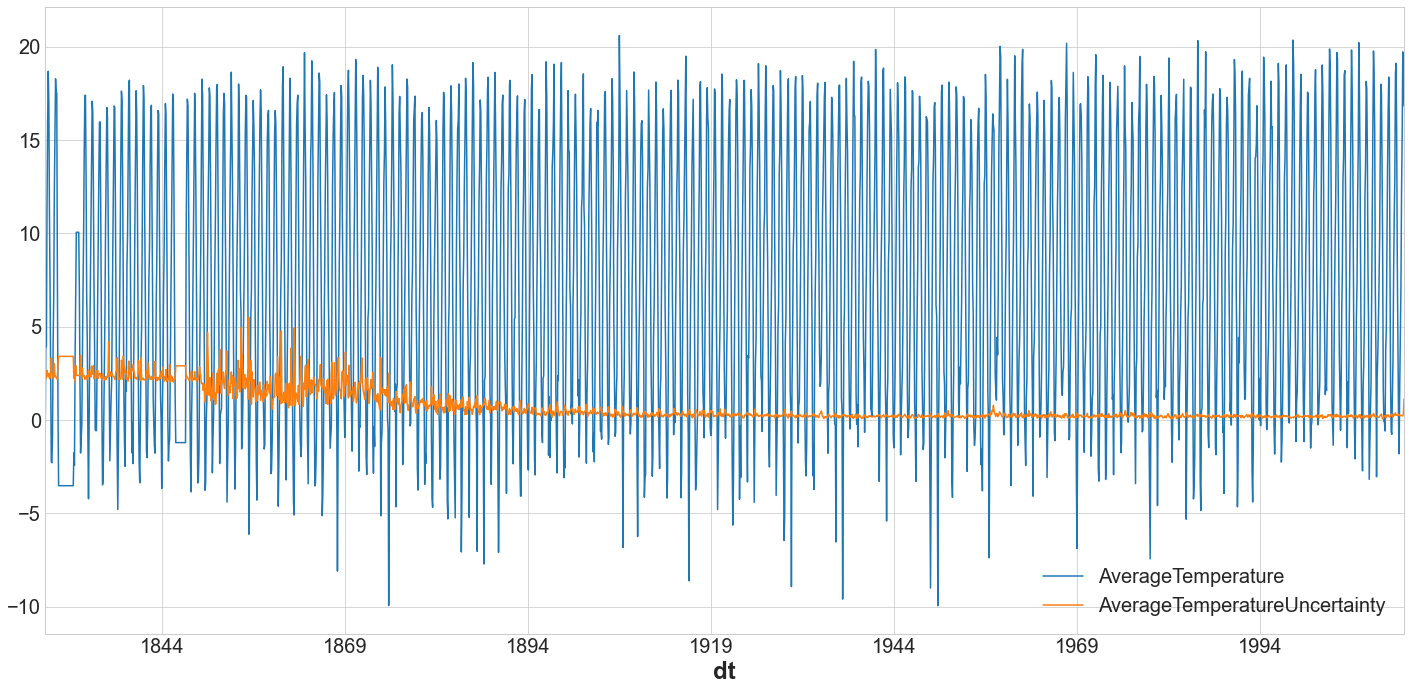

In [15]:
wash.plot()

The earlier data has some anamolies probably due to either the fillna method or issues with data collection. I will only use data later than 1850.

I also will split the data into epochs, I want to ensure that each data set has periods of warming due to human driven global warming starting at the 20th century. 

In [16]:
train = wash['1850':'1949']
validate = wash['1950':'1999']
test = wash['2000':]

In [17]:
year = train.resample('1Y').mean()

<AxesSubplot:xlabel='dt'>

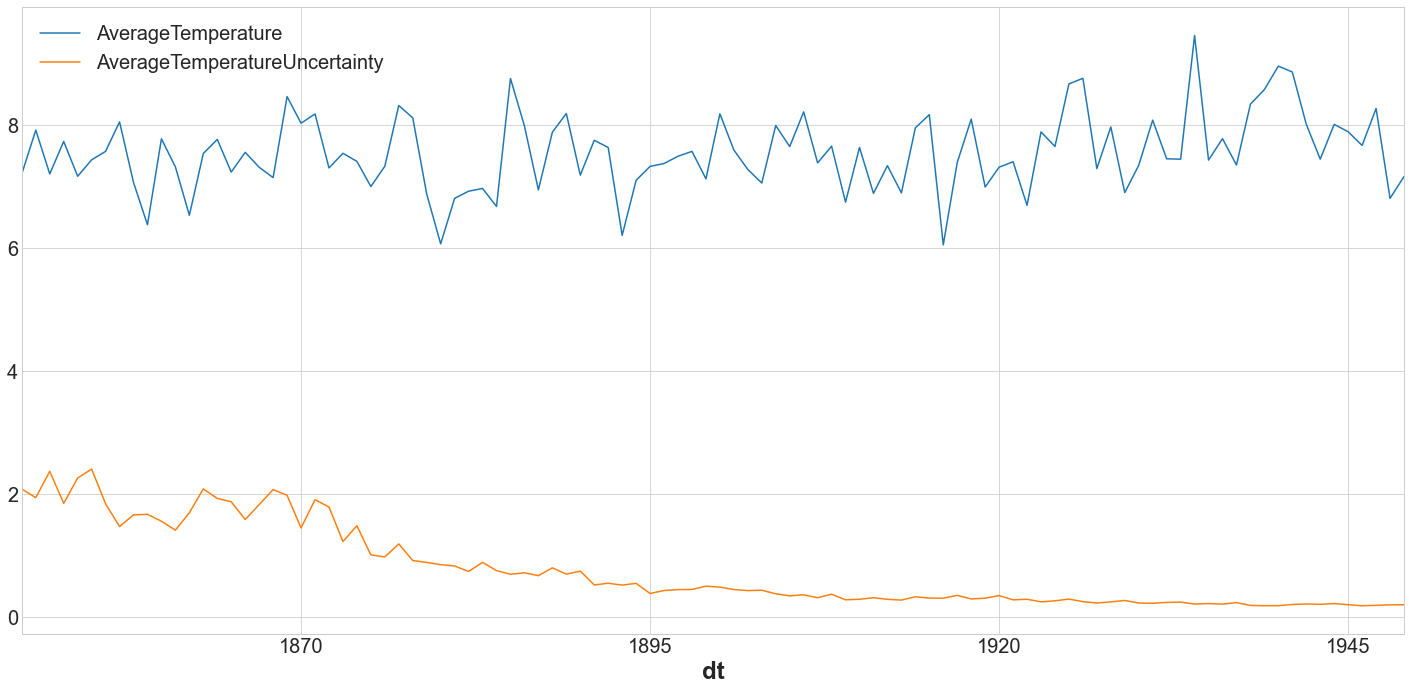

In [18]:
year.plot()

In [19]:
year.shape

(100, 2)

In [20]:
month = train.resample('1M').mean()

<AxesSubplot:xlabel='dt'>

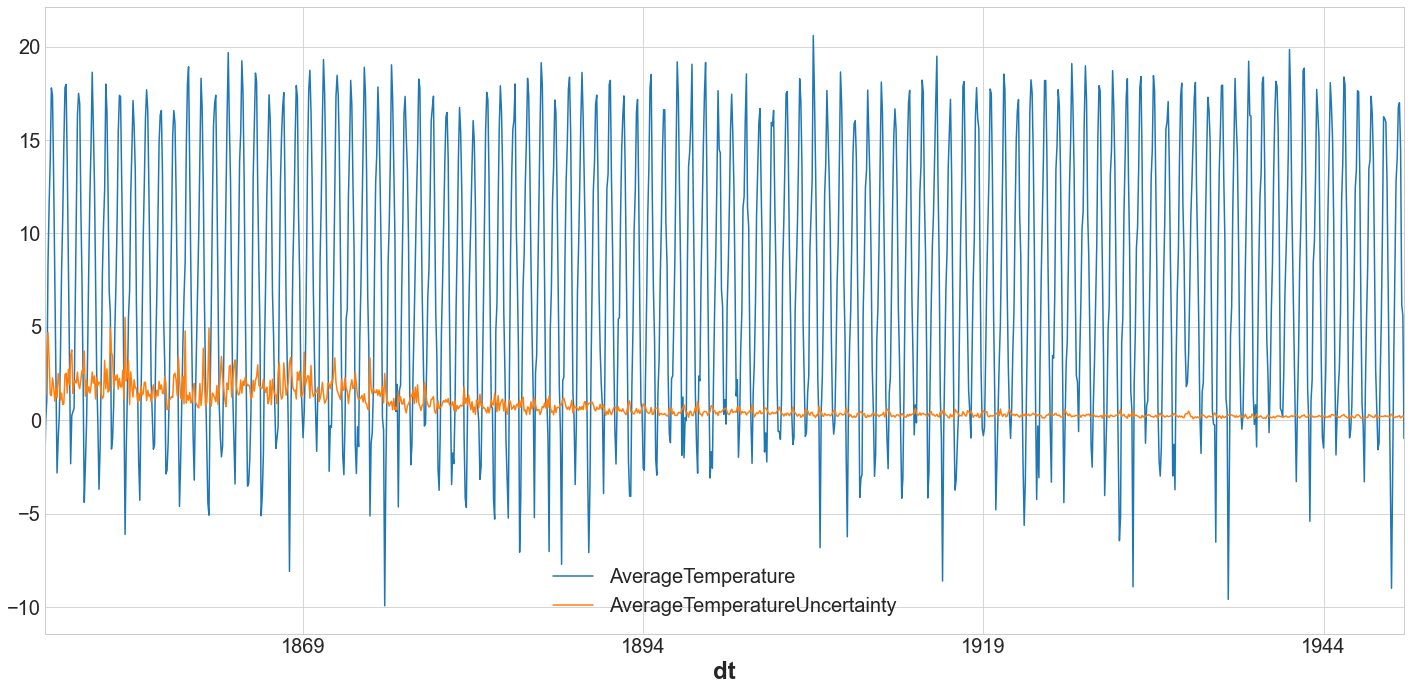

In [21]:
month.plot()

<AxesSubplot:xlabel='dt'>

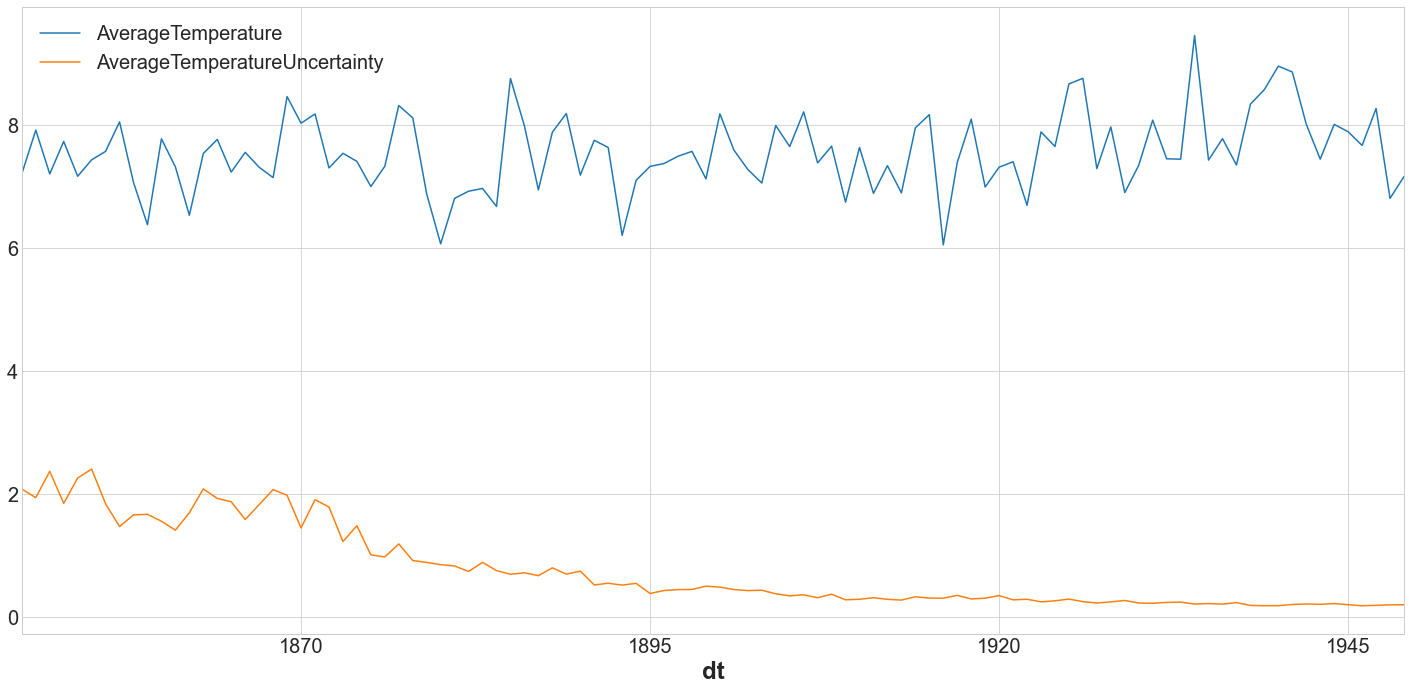

In [22]:
year.plot()

<AxesSubplot:xlabel='dt'>

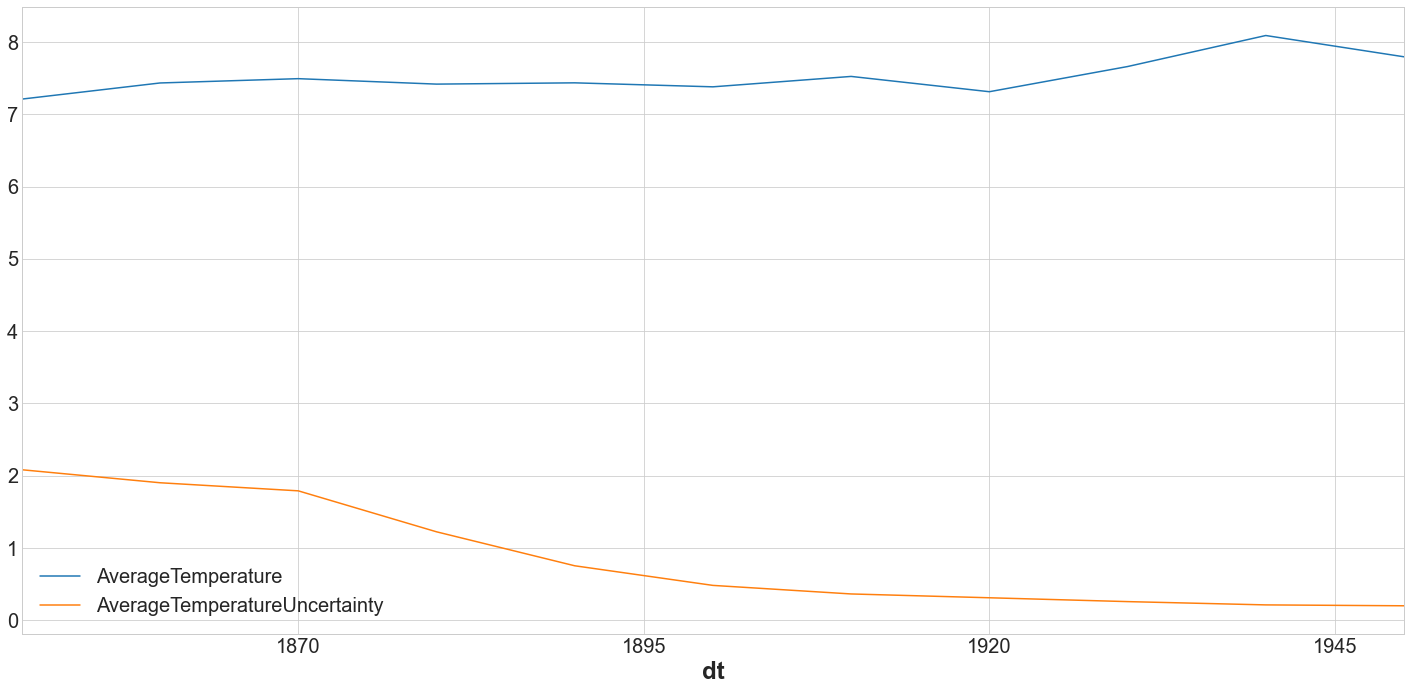

In [23]:
train.loc['1850':].resample('10Y').mean().plot()

Beacause there is quite a bit of data at the smaller levels, it is hard to see seasonality. I will look at only about 5 years to see the seasonality. 

<AxesSubplot:xlabel='dt'>

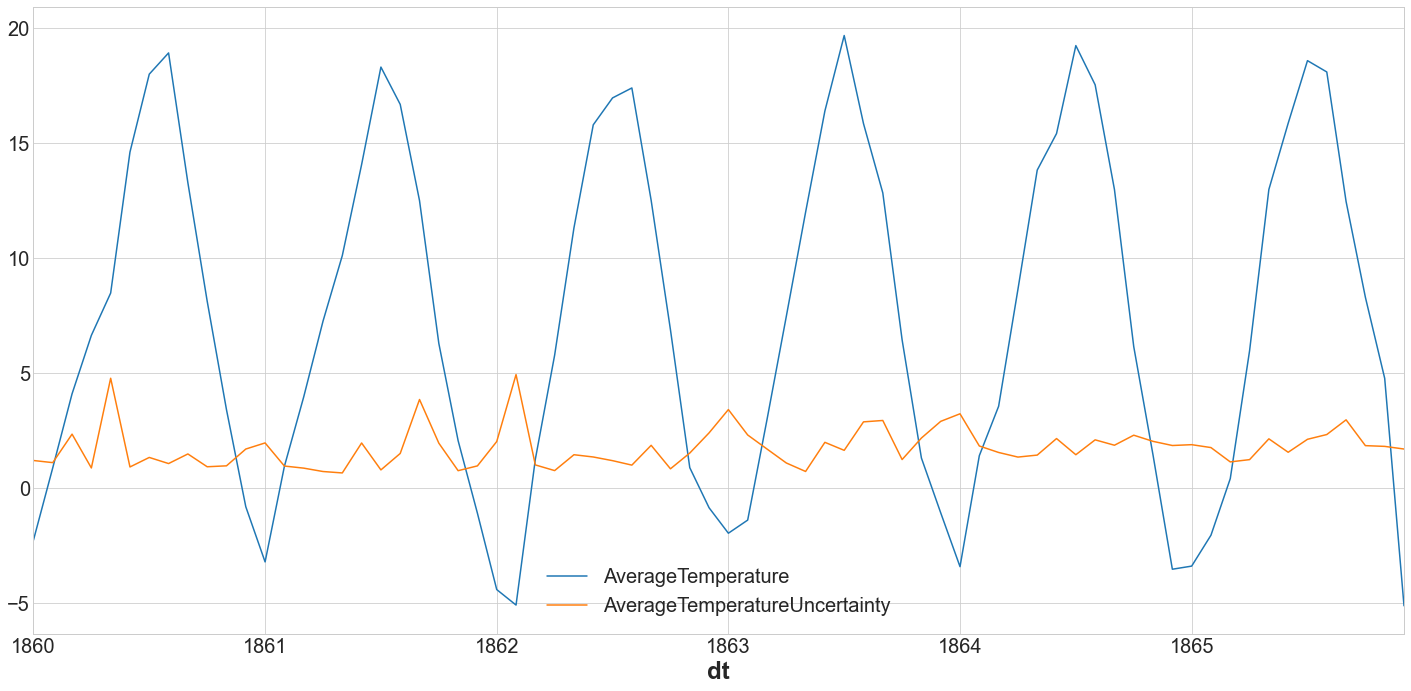

In [24]:
train.loc['1860':'1865'].resample('1M').mean().plot()

Takeaways from the plots:
- Slight increase in overall temperature, but for the most part the trend is pretty flat
- Temp uncertainty goes down as time goes on, which makes sense as recording technology would have improved with time. 
- The range of temperatures is pretty similar across years

In [25]:
train.columns

Index(['AverageTemperature', 'AverageTemperatureUncertainty', 'State',
       'Country'],
      dtype='object')

In [26]:
train = train.drop(columns = ['State','Country'])
validate = validate.drop(columns = ['State','Country'])
test = test.drop(columns = ['State','Country'])

In [27]:
train = train.loc['1850':]

In [28]:
train.describe()

,AverageTemperature,AverageTemperatureUncertainty
count,1200.000000,1200.000000
mean,7.547608,0.767669
std,7.099343,0.766338
min,-9.938000,0.073000
25%,1.331500,0.242750
50%,7.572500,0.432000
75%,13.792250,1.042250
max,20.593000,5.504000


#### Decomposition

In [29]:
y = train['AverageTemperature']
month = y.resample('6M').mean()
result = sm.tsa.seasonal_decompose(month)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})
decomposition.head()

,y,trend,seasonal,resid
dt,,,,
1850-01-31,-3.352000,NaN,-1.394316,NaN
1850-07-31,8.770333,NaN,1.529058,NaN
1851-01-31,6.037833,6.439042,-1.494187,1.092979
1851-07-31,9.197000,7.716062,1.359445,0.121493
1852-01-31,6.854000,7.611896,-1.394316,0.636420


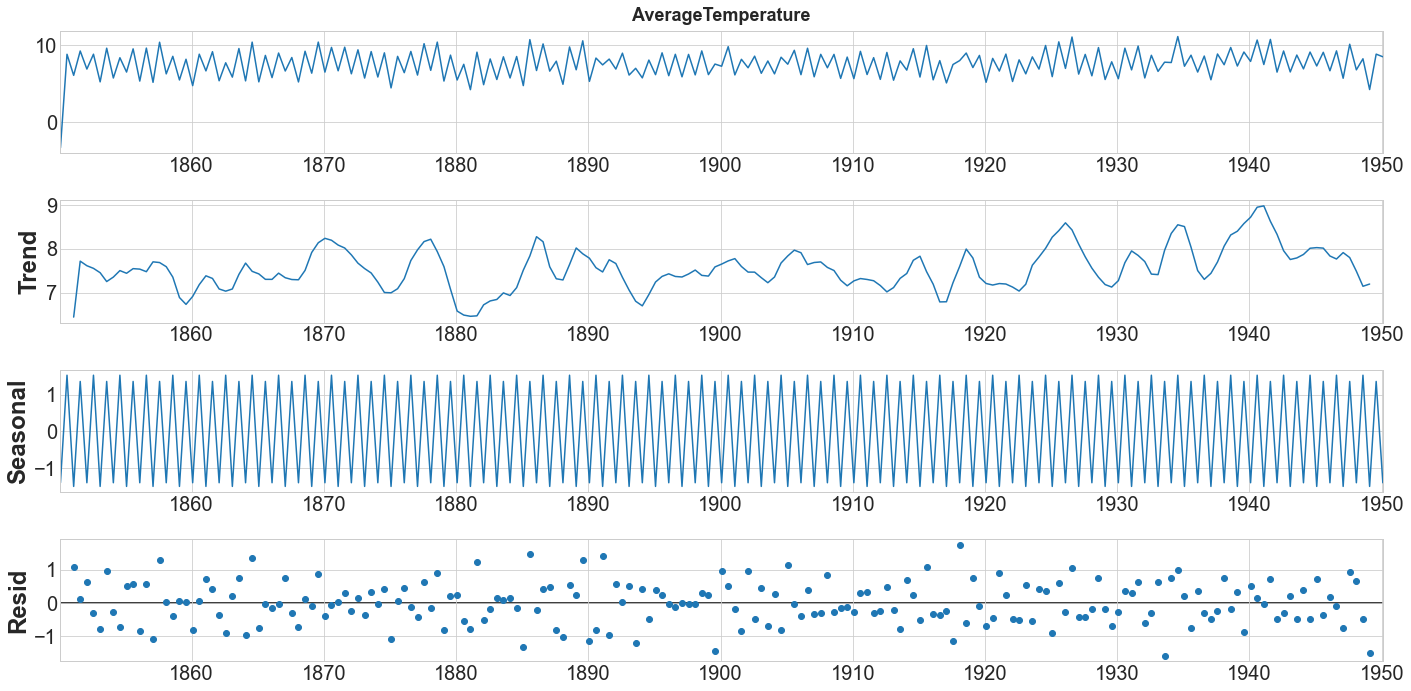

In [30]:
result.plot()
None

In [31]:
y = train['AverageTemperature']
month = y.resample('10Y').mean()
result = sm.tsa.seasonal_decompose(month)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})


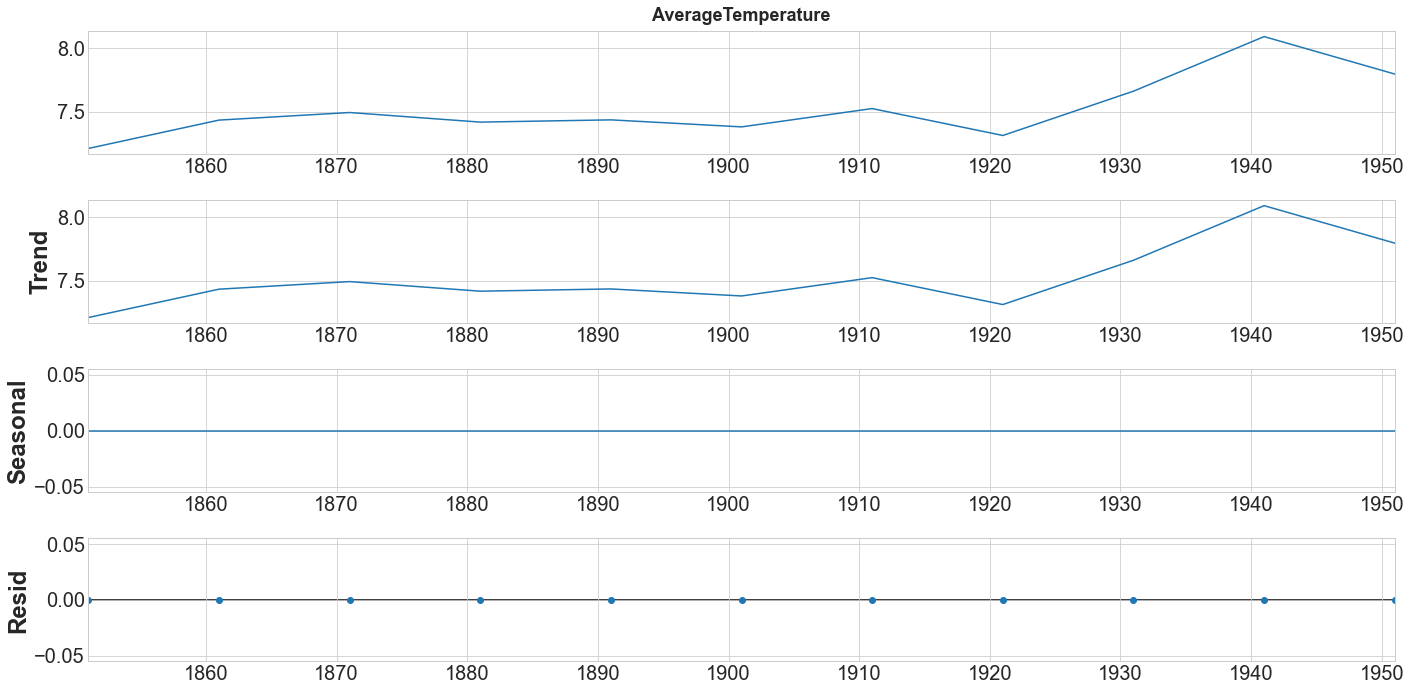

In [32]:
result.plot()
None

Decomposition Takeaways:
- In the 6M decomp, seasonality is easily seen, and the trendline shows that the earlier and later parts of the data set had much greater changes inm temperature than the middle. 
- Residuals have a constant spread indicating that the variance in temperature is consistent over time 

#### Autocorrelation

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

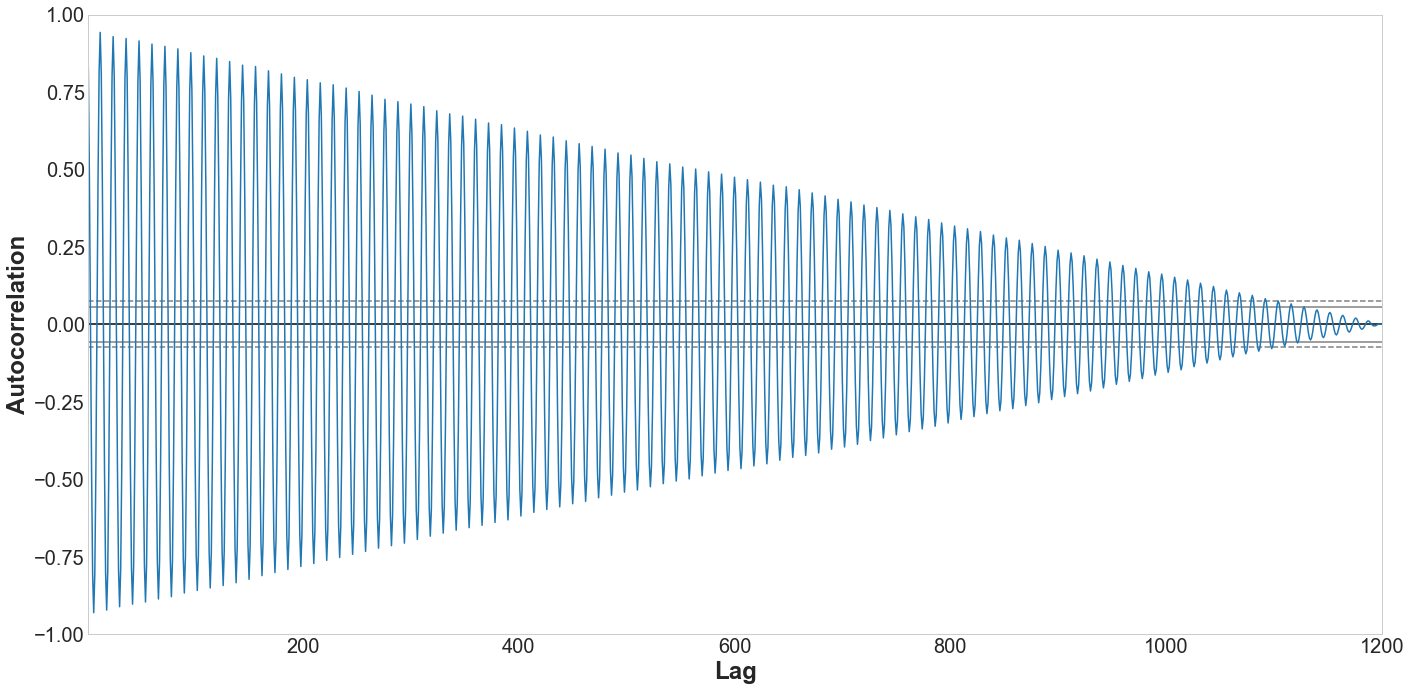

In [33]:
pd.plotting.autocorrelation_plot(y.resample('1M').mean())

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

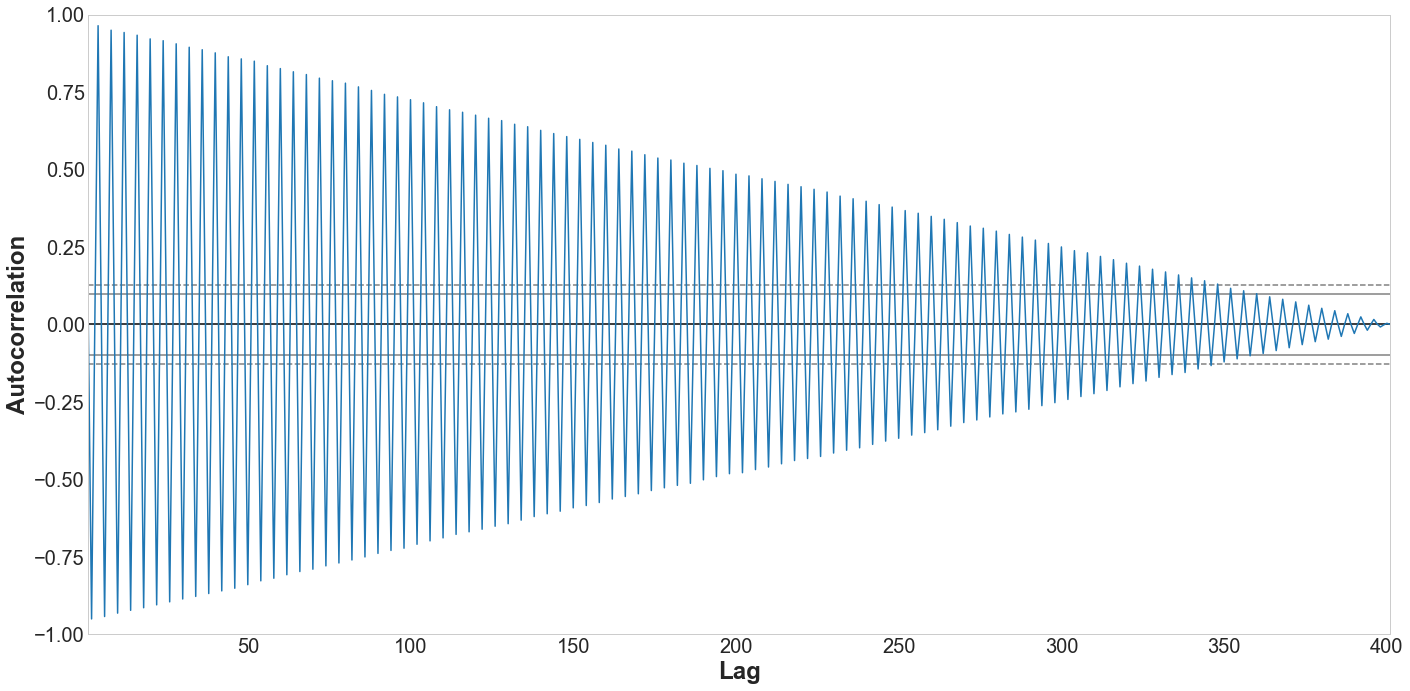

In [34]:
pd.plotting.autocorrelation_plot(y.resample('3M').mean())

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

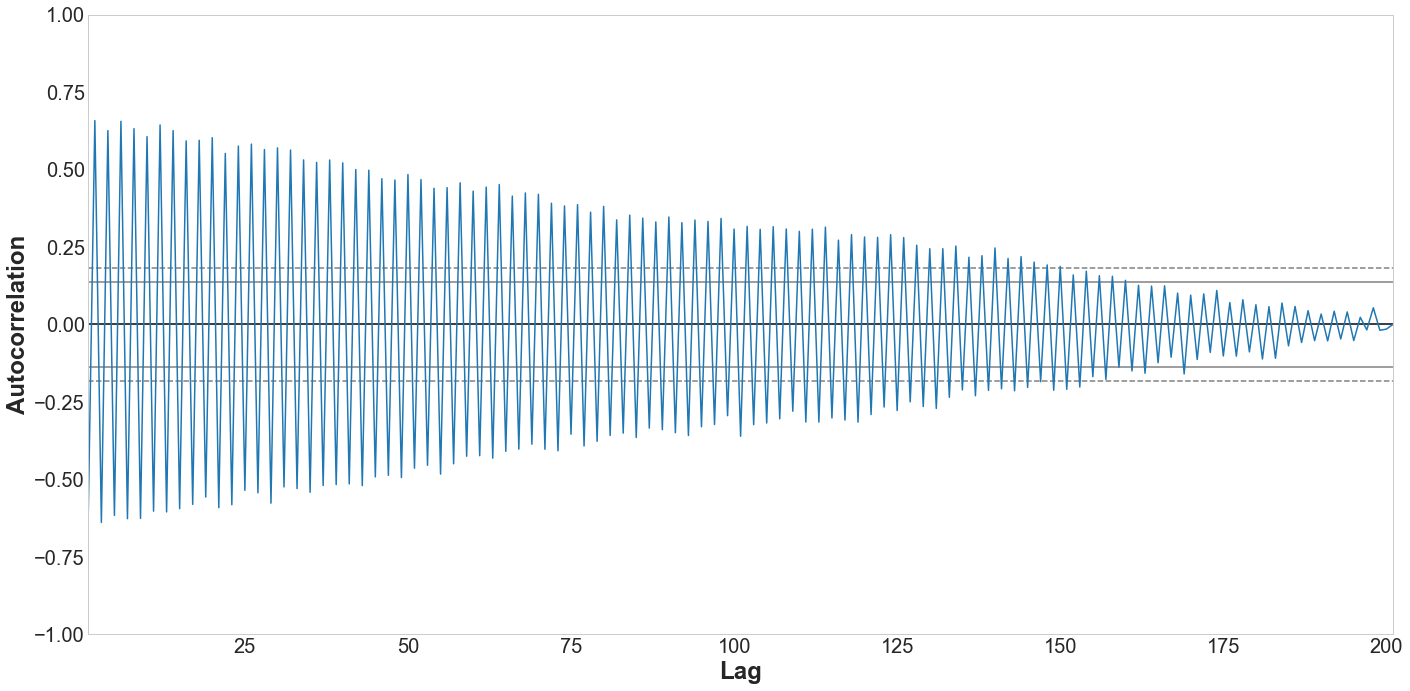

In [35]:
pd.plotting.autocorrelation_plot(y.resample('6M').mean())

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

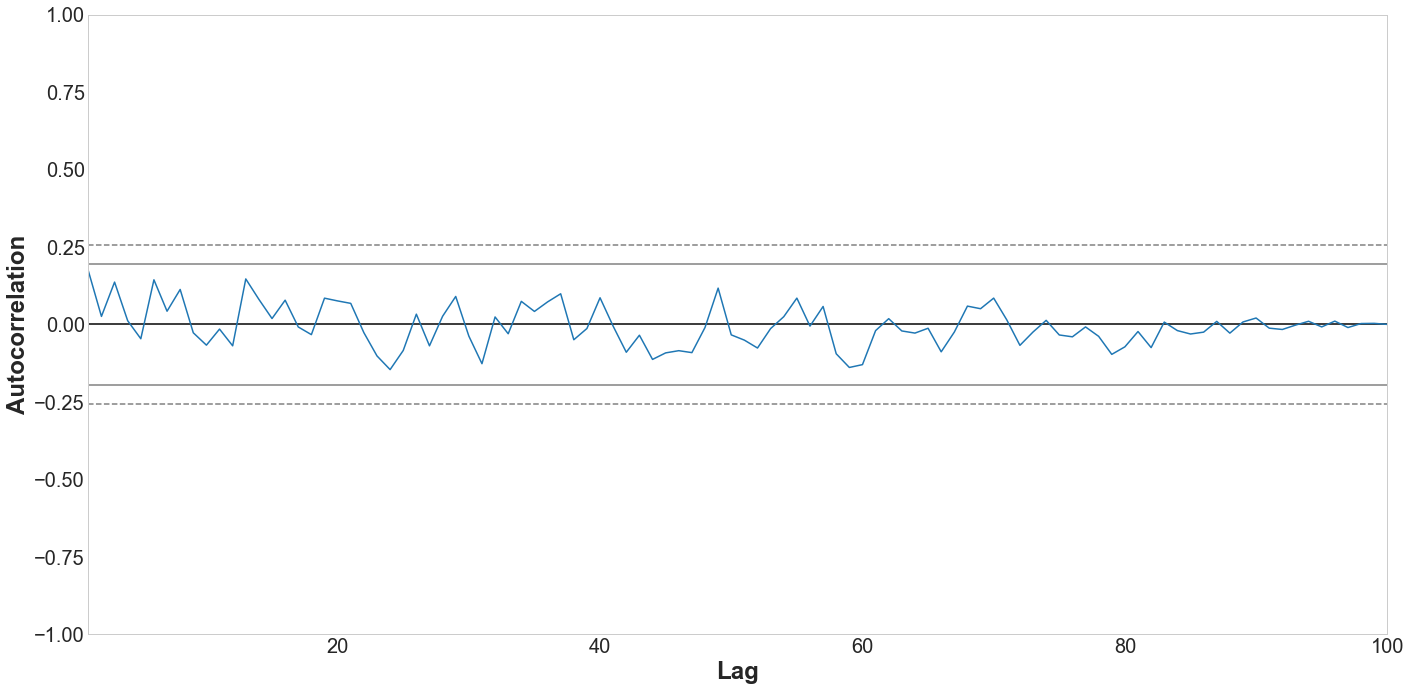

In [36]:
pd.plotting.autocorrelation_plot(y.resample('1Y').mean())

Autocorrelation Takeaways:
- The correlation between values decreases as the time interval increases. By one year, values are within the 99% confidence interval, indicating it is not correlated. 
- 3 month period seems to be the best, as it averages a few data points and does not lose its correlative strength

#### Percent change

<AxesSubplot:xlabel='dt'>

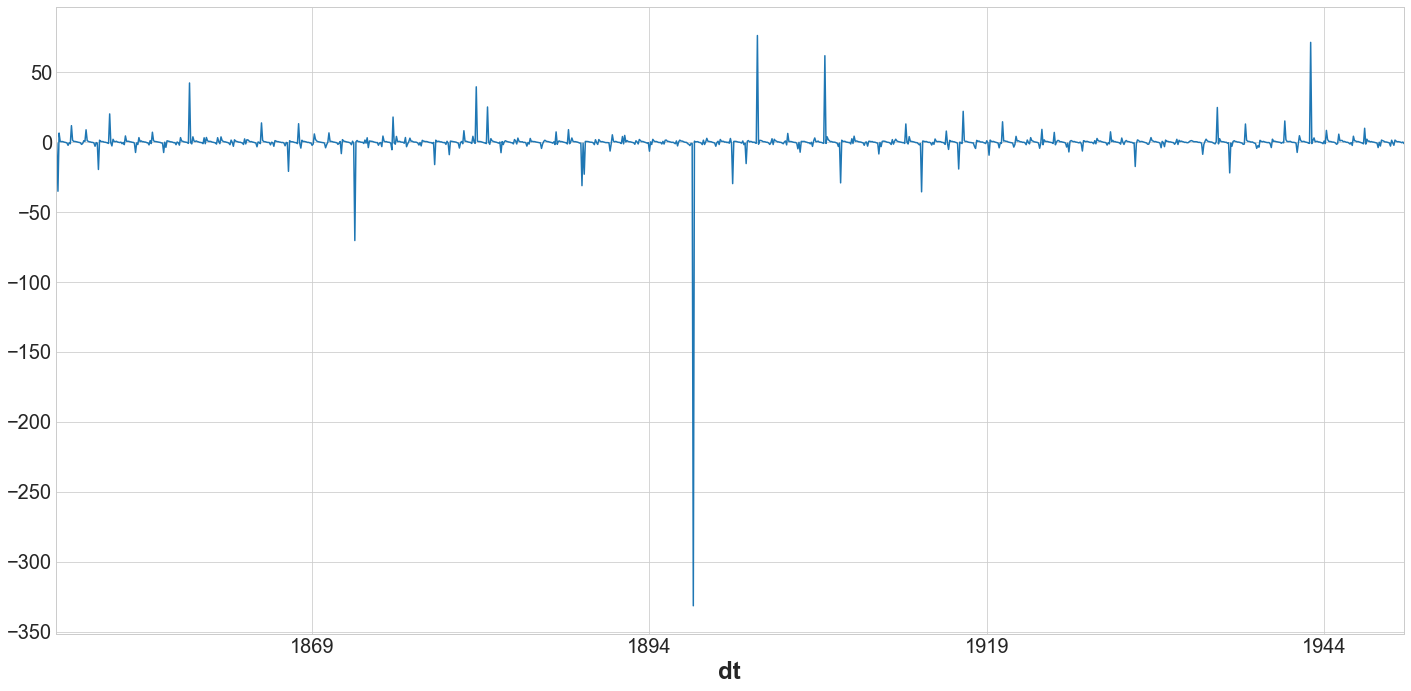

In [37]:
y.pct_change().plot()

What's causing that huge drop around 1895? Lets just take a peak

<AxesSubplot:xlabel='dt'>

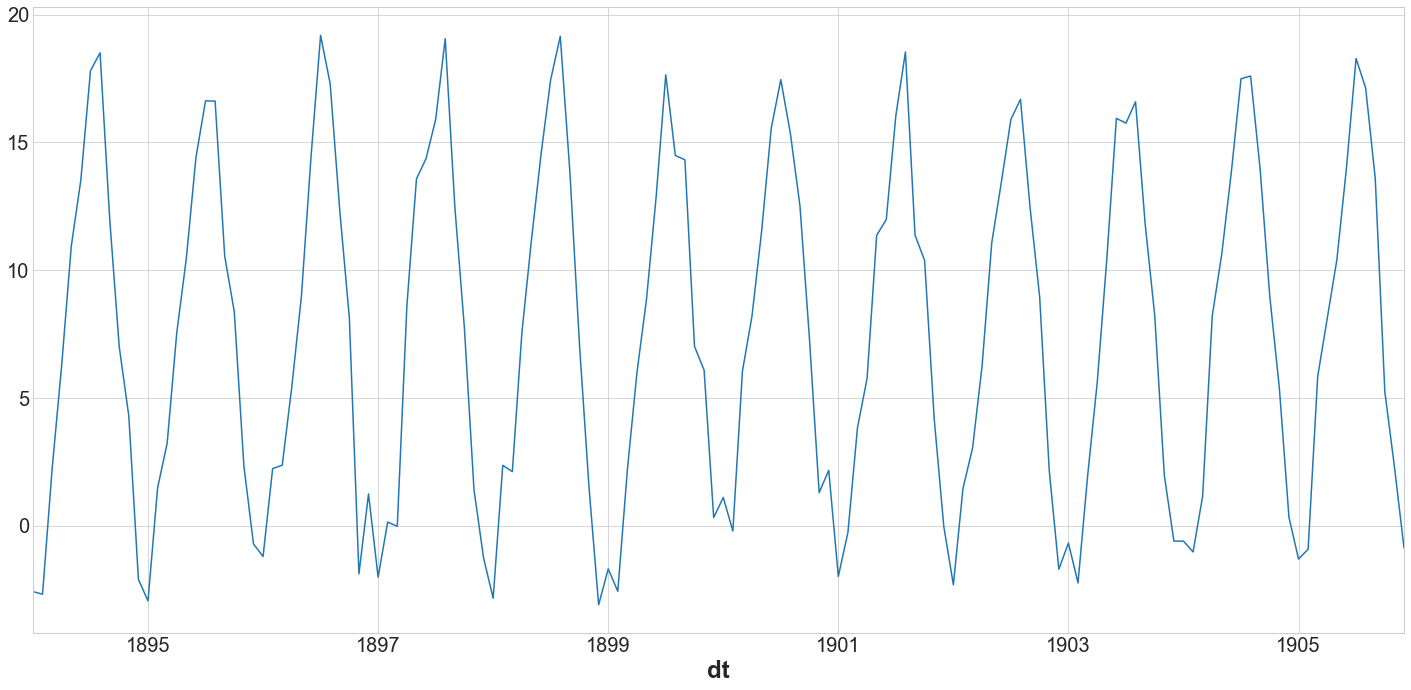

In [38]:
y.loc['1894':'1905'].plot()

It seems that the data is fine, there were just some fluctuations that resulted in an extremely large percent change due to temperatures being very low. 

## Forecasting 

#### Last Known Value

In [83]:
temp = train['AverageTemperature'][-1:][0]

yhat_df = pd.DataFrame({'AverageTemperature': [temp]},index = validate.index)
yhat_df.head(2)

,AverageTemperature
dt,
1950-01-01,-0.983
1950-02-01,-0.983


Last Known Value -- RMSE: 11.244


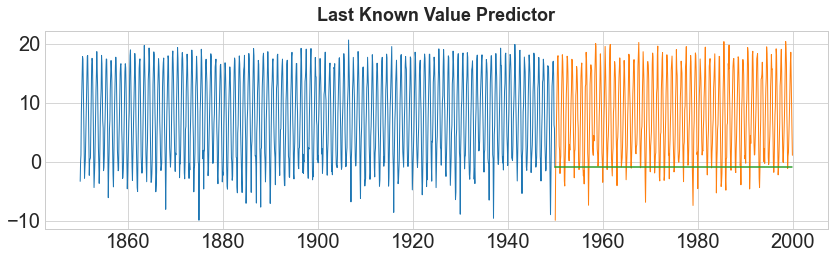

In [84]:
plt.figure(figsize = (12,4))
plt.plot(train['AverageTemperature'], label='Train', linewidth=1)
plt.plot(validate['AverageTemperature'], label='Validate', linewidth=1)
plt.plot(yhat_df['AverageTemperature'])
plt.title('Last Known Value Predictor')
rmse = round(sqrt(mean_squared_error(validate['AverageTemperature'], yhat_df['AverageTemperature'])), 3)
print('Last Known Value -- RMSE: {:.3f}'.format(rmse))
plt.show()

Takeaways:
- This is pretty bad. But to be fair, it's not exactly the smartest solution.

#### Simple Average

In [85]:
temp = round(train['AverageTemperature'].mean(), 2)
yhat_df = pd.DataFrame({'AverageTemperature': [temp]},index = validate.index)
yhat_df.head(2)

,AverageTemperature
dt,
1950-01-01,7.55
1950-02-01,7.55


Simple Average -- RMSE: 6.904


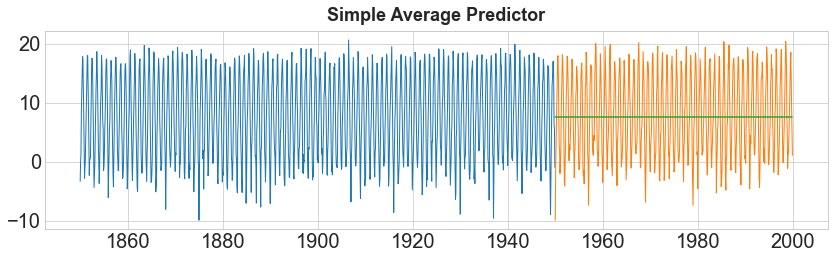

In [86]:
plt.figure(figsize = (12,4))
plt.plot(train['AverageTemperature'], label='Train', linewidth=1)
plt.plot(validate['AverageTemperature'], label='Validate', linewidth=1)
plt.plot(yhat_df['AverageTemperature'])
plt.title('Simple Average Predictor')
rmse = round(sqrt(mean_squared_error(validate['AverageTemperature'], yhat_df['AverageTemperature'])), 3)
print('Simple Average -- RMSE: {:.3f}'.format(rmse))
plt.show()

In [91]:
temp = round(train['AverageTemperature'].rolling(12).mean().iloc[-1],2)
yhat_df = pd.DataFrame({'AverageTemperature': [temp]},index = validate.index)

1Y average -- RMSE: 6.935


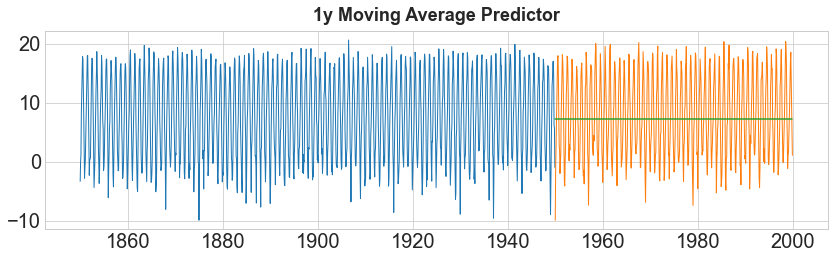

In [92]:
plt.figure(figsize = (12,4))
plt.plot(train['AverageTemperature'], label='Train', linewidth=1)
plt.plot(validate['AverageTemperature'], label='Validate', linewidth=1)
plt.plot(yhat_df['AverageTemperature'])
plt.title('1y Moving Average Predictor')
rmse = round(sqrt(mean_squared_error(validate['AverageTemperature'], yhat_df['AverageTemperature'])), 3)
print('1Y average -- RMSE: {:.3f}'.format(rmse))
plt.show()

6mo average -- RMSE: 7.164


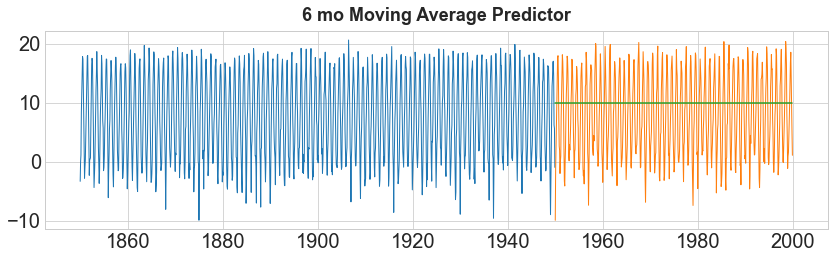

In [93]:
temp = round(train['AverageTemperature'].rolling(6).mean().iloc[-1],2)
yhat_df = pd.DataFrame({'AverageTemperature': [temp]},index = validate.index)
plt.figure(figsize = (12,4))
plt.plot(train['AverageTemperature'], label='Train', linewidth=1)
plt.plot(validate['AverageTemperature'], label='Validate', linewidth=1)
plt.plot(yhat_df['AverageTemperature'])
plt.title('6 mo Moving Average Predictor')
rmse = sqrt(mean_squared_error(validate['AverageTemperature'], yhat_df['AverageTemperature']))
print('6mo average -- RMSE: {:.3f}'.format(rmse))
plt.show()

3mo average -- RMSE: 8.126


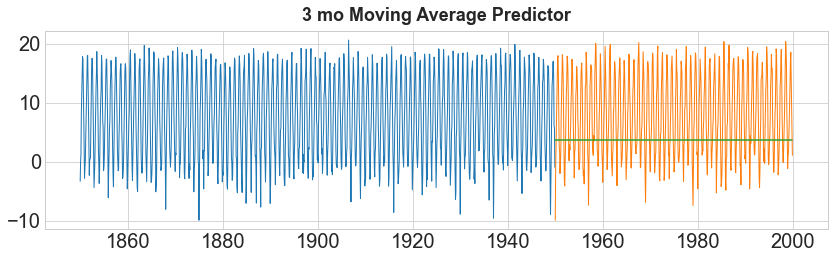

In [94]:
temp = round(train['AverageTemperature'].rolling(3).mean().iloc[-1],2)
yhat_df = pd.DataFrame({'AverageTemperature': [temp]},index = validate.index)
plt.figure(figsize = (12,4))
plt.plot(train['AverageTemperature'], label='Train', linewidth=1)
plt.plot(validate['AverageTemperature'], label='Validate', linewidth=1)
plt.plot(yhat_df['AverageTemperature'])
plt.title('3 mo Moving Average Predictor')
rmse = sqrt(mean_squared_error(validate['AverageTemperature'], yhat_df['AverageTemperature']))
print('3mo average -- RMSE: {:.3f}'.format(rmse))
plt.show()

Takeaways: 
- both the 3mo, 6mo and 12mo moving averages did not improve on the forcast compared to a simple average. 
- Makes sense because at the end of the day, it is still just making an average and the values have a very similar variance.

#### Holt smoothing

In [153]:
model = Holt(train['AverageTemperature'], exponential = False)
model = model.fit(smoothing_level = .03, smoothing_trend = .1, optimized = True)
yhat_temp = model.predict(start = validate.index[0], 
                           end = validate.index[-1])
yhat_df['AverageTemperature'] = round(yhat_temp, 2)

/Users/parkervoit/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Holt average -- RMSE: 6.904


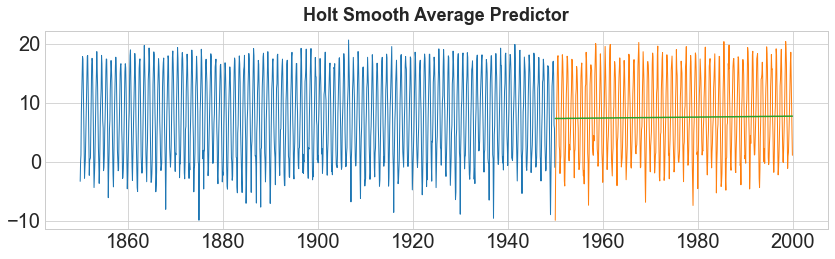

In [154]:
plt.figure(figsize = (12,4))
plt.plot(train['AverageTemperature'], label='Train', linewidth=1)
plt.plot(validate['AverageTemperature'], label='Validate', linewidth=1)
plt.plot(yhat_df['AverageTemperature'])
plt.title('Holt Smooth Average Predictor')
rmse = sqrt(mean_squared_error(validate['AverageTemperature'], yhat_df['AverageTemperature']))
print('Holt average -- RMSE: {:.3f}'.format(rmse))
plt.show()

Takeaway: 
- RMSE again is not much better than a simple average. 

#### Cyclical prediction

In [169]:
yhat_df = train.loc['1900':'1949'] + train.diff(12).mean()

In [170]:
yhat_df 

,AverageTemperature,AverageTemperatureUncertainty
dt,,
1900-01-01,1.103545,0.601973
1900-02-01,-0.210455,0.622973
1900-03-01,6.047545,0.421973
1900-04-01,8.212545,0.296973
1900-05-01,11.519545,0.276973
...,...,...
1949-08-01,16.995545,0.224973
1949-09-01,14.450545,0.103973
1949-10-01,6.187545,0.153973


In [171]:
yhat_df.index = validate.index

In [172]:
yhat_df

,AverageTemperature,AverageTemperatureUncertainty
dt,,
1950-01-01,1.103545,0.601973
1950-02-01,-0.210455,0.622973
1950-03-01,6.047545,0.421973
1950-04-01,8.212545,0.296973
1950-05-01,11.519545,0.276973
...,...,...
1999-08-01,16.995545,0.224973
1999-09-01,14.450545,0.103973
1999-10-01,6.187545,0.153973


Cyclical -- RMSE: 2.194


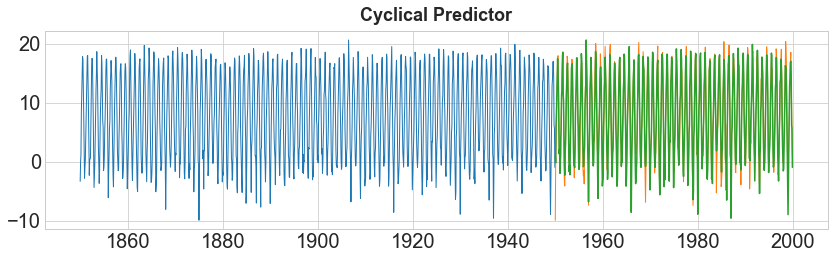

In [173]:
plt.figure(figsize = (12,4))
plt.plot(train['AverageTemperature'], label='Train', linewidth=1)
plt.plot(validate['AverageTemperature'], label='Validate', linewidth=1)
plt.plot(yhat_df['AverageTemperature'])
plt.title('Cyclical Predictor')
rmse = sqrt(mean_squared_error(validate['AverageTemperature'], yhat_df['AverageTemperature']))
print('Cyclical -- RMSE: {:.3f}'.format(rmse))
plt.show()

Takeaways:
- the cyclical predictor performs the best, as expected. 
- Next step is to fit on train+validate and then use it to predict from 2000-2013

## Testing

In [176]:
train.index

DatetimeIndex(['1850-01-01', '1850-02-01', '1850-03-01', '1850-04-01',
               '1850-05-01', '1850-06-01', '1850-07-01', '1850-08-01',
               '1850-09-01', '1850-10-01',
               ...
               '1949-03-01', '1949-04-01', '1949-05-01', '1949-06-01',
               '1949-07-01', '1949-08-01', '1949-09-01', '1949-10-01',
               '1949-11-01', '1949-12-01'],
              dtype='datetime64[ns]', name='dt', length=1200, freq=None)

In [175]:
validate.index

DatetimeIndex(['1950-01-01', '1950-02-01', '1950-03-01', '1950-04-01',
               '1950-05-01', '1950-06-01', '1950-07-01', '1950-08-01',
               '1950-09-01', '1950-10-01',
               ...
               '1999-03-01', '1999-04-01', '1999-05-01', '1999-06-01',
               '1999-07-01', '1999-08-01', '1999-09-01', '1999-10-01',
               '1999-11-01', '1999-12-01'],
              dtype='datetime64[ns]', name='dt', length=600, freq=None)

In [188]:
train_val = wash.loc['1850':'1999'].drop(columns = ['Country','State'])

In [189]:
train_val.index

DatetimeIndex(['1850-01-01', '1850-02-01', '1850-03-01', '1850-04-01',
               '1850-05-01', '1850-06-01', '1850-07-01', '1850-08-01',
               '1850-09-01', '1850-10-01',
               ...
               '1999-03-01', '1999-04-01', '1999-05-01', '1999-06-01',
               '1999-07-01', '1999-08-01', '1999-09-01', '1999-10-01',
               '1999-11-01', '1999-12-01'],
              dtype='datetime64[ns]', name='dt', length=1800, freq=None)

In [190]:
test.index

DatetimeIndex(['2000-01-01', '2000-02-01', '2000-03-01', '2000-04-01',
               '2000-05-01', '2000-06-01', '2000-07-01', '2000-08-01',
               '2000-09-01', '2000-10-01',
               ...
               '2012-12-01', '2013-01-01', '2013-02-01', '2013-03-01',
               '2013-04-01', '2013-05-01', '2013-06-01', '2013-07-01',
               '2013-08-01', '2013-09-01'],
              dtype='datetime64[ns]', name='dt', length=165, freq=None)

In [196]:
yhat_df = train_val.loc['1986':'1999-09-01'] + train_val.diff(12).mean()

In [197]:
yhat_df

,AverageTemperature,AverageTemperatureUncertainty
dt,,
1986-01-01,0.463933,0.262321
1986-02-01,0.661933,0.223321
1986-03-01,6.172933,0.186321
1986-04-01,6.524933,0.185321
1986-05-01,11.519933,0.229321
...,...,...
1999-05-01,9.519933,0.132321
1999-06-01,13.540933,0.164321
1999-07-01,16.747933,0.181321


In [199]:
yhat_df.index = test.index

Cyclical -- RMSE: 1.937


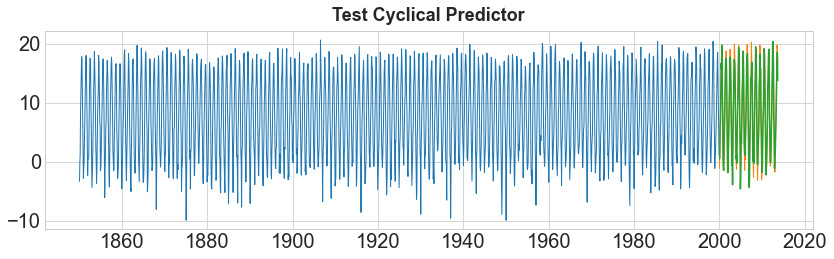

In [201]:
plt.figure(figsize = (12,4))
plt.plot(train_val['AverageTemperature'], label='Train', linewidth=1)
plt.plot(test['AverageTemperature'], label='Validate', linewidth=1)
plt.plot(yhat_df['AverageTemperature'])
plt.title('Test Cyclical Predictor')
rmse = sqrt(mean_squared_error(test['AverageTemperature'], yhat_df['AverageTemperature']))
print('Cyclical -- RMSE: {:.3f}'.format(rmse))
plt.show()

In [231]:
yhat_df = test + train_val.diff(12).mean()
yhat_df.index = test.index + pd.Timedelta('5Y')

In [232]:
train_val.diff(12).mean()

AverageTemperature               0.006933
AverageTemperatureUncertainty   -0.012679
dtype: float64

In [233]:
test + train_val.diff(12).mean()

,AverageTemperature,AverageTemperatureUncertainty
dt,,
2000-01-01,-1.158067,0.207321
2000-02-01,1.507933,0.231321
2000-03-01,4.006933,0.179321
2000-04-01,8.730933,0.201321
2000-05-01,10.894933,0.177321
...,...,...
2013-05-01,12.292933,0.246321
2013-06-01,15.221933,0.220321
2013-07-01,19.723933,0.203321


In [234]:
yhat_df.index = test.index + pd.Timedelta('13Y')

In [235]:
yhat_df

,AverageTemperature,AverageTemperatureUncertainty
dt,,
2012-12-31 03:39:36,-1.158067,0.207321
2013-01-31 03:39:36,1.507933,0.231321
2013-03-01 03:39:36,4.006933,0.179321
2013-04-01 03:39:36,8.730933,0.201321
2013-05-01 03:39:36,10.894933,0.177321
...,...,...
2026-05-01 03:39:36,12.292933,0.246321
2026-06-01 03:39:36,15.221933,0.220321
2026-07-01 03:39:36,19.723933,0.203321


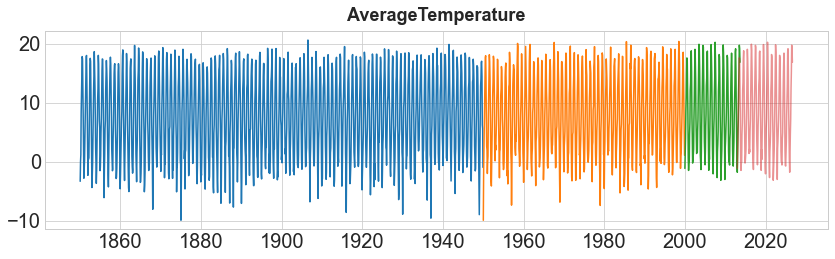

In [236]:
target_var = 'AverageTemperature'
plt.figure(figsize=(12,4))
plt.plot(train[target_var], label='train')
plt.plot(validate[target_var], label='validate')
plt.plot(test[target_var], label='test')
plt.plot(yhat_df[target_var], alpha=.5)
plt.title(target_var)
plt.show()

In [238]:
yhat_df['2021-06']['AverageTemperature']

dt
2021-06-01 03:39:36    13.704933
Name: AverageTemperature, dtype: float64

In [242]:
(yhat_df['2021-07']['AverageTemperature'][0] * 1.8) + 32

64.65008020134229

#### Conclusion 
1. Using a cyclical predictor had the best performance with an RMSE near 2. 
2. When predicted into the future, the model tends to be under the average monthly temperature in Washington according to http://www.rssweather.com/climate/Washington/Seattle%20C.O./
3. Weather was rather consistent across the whole data set barring the last few years as the average temperature began to increase. For that reason, I chose to split up the data in such a way that there was some portion of modern warming in each split. 
4. Since the test was over the span of 13 years, I decided to input that as the Timedelta argument to line up on the graph and predict the same length of time. 